# Generacion de datos sinteticos para el modelo

## Fase 1: Configuración y Parámetros del Entorno 🛠️

Esta sección será la "consola de control" de tu simulación. Definiremos todas las variables aquí para que sea fácil experimentar.

    Parámetros Físicos del Robot:

        DISTANCIA_ENTRE_SENSORES: La separación física entre los sensores (ej. 15 cm).

        DISTANCIA_DE_ENFOQUE: Tu distancia de enfoque óptima (150 cm).

    Parámetros de Barrido:

        RANGO_DE_ANGULO: El campo de visión total (140 grados).

        NUMERO_DE_PASOS: Cuántas "fotografías" tomará el sonar para cubrir el rango. Esto definirá el PASO_ANGULAR.

        ANGULOS_DE_BARRIDO: La lista de ángulos discretos que el sensor central usará (ej. [70, 46.6, ...]).

    Parámetros del Sensor:

        SINGLE_BEAM_SHAPE_POINTS: La lista de coordenadas que definen la forma del lóbulo realista que mediste.

    Parámetros de la Simulación:

        NUM_MUESTRAS_POR_PASO: Cuántos objetos aleatorios generar para cada uno de los ángulos de barrido.

        TIPOS_DE_OBJETO: Una lista de geometrías a simular (ej. ['circulo', 'rectangulo']).

        RANGO_DE_TAMAÑO_OBJETO: Los tamaños mínimos y máximos de los objetos.

    Parámetros del Espacio de Salida (para el ML):

        TAMAÑO_DEL_CUADRANTE: El grano de tu rejilla de detección (6 cm).

## Fase 2: Funciones de Modelado Geométrico 📐

Aquí pondremos las funciones reutilizables que se encargan de la geometría, basadas en lo que ya hemos desarrollado.

    obtener_angulos_optimos(theta_central): La función que ya tenemos, que calcula los ángulos de los sensores laterales.

    crear_haz_desde_puntos(...): La función que toma los puntos del lóbulo y crea el polígono shapely base.

    generar_area_de_barrido(angulo_central): Una nueva función clave que:

        Toma el ángulo del sensor central.

        Calcula los ángulos óptimos de los laterales.

        Crea las tres geometrías de los haces (lóbulos).

        Las rota y traslada a sus posiciones correctas.

        Devuelve la unión de los tres haces, que es el área total de detección para ese paso de barrido.

In [7]:
# Importar las librerías necesarias para esta fase
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely import affinity

# ===================================================================
# FASE 1: Configuración y Parámetros del Entorno
# ===================================================================
# En esta sección defines el comportamiento de toda la simulación.

# --- Parámetros Físicos del Robot ---
DISTANCIA_ENTRE_SENSORES = 15  # cm
DISTANCIA_DE_ENFOQUE = 150 # cm (Tu distancia de enfoque óptima)

# --- Parámetros de Barrido ---
RANGO_DE_ANGULO = 140.0  # Grados (Campo de visión total)
NUMERO_DE_PASOS = 9      # Cantidad de "fotografías" del sonar
PASO_ANGULAR = RANGO_DE_ANGULO / (NUMERO_DE_PASOS - 1) # Calculamos el paso para incluir los extremos
ANGULOS_DE_BARRIDO = np.linspace(-RANGO_DE_ANGULO / 2, RANGO_DE_ANGULO / 2, NUMERO_DE_PASOS)

# --- Parámetros del Sensor (Lóbulo Realista) ---
SINGLE_BEAM_SHAPE_POINTS = [
    (0.00, 0.00), (0.035, 0.12), (0.06, 0.3), (0.11, 0.6), (0.255, 1.3),
    (0.405, 1.54), (0.32, 1.8), (0.11, 1.99), (-0.11, 1.99), (-0.32, 1.8),
    (-0.405, 1.54), (-0.255, 1.3), (-0.11, 0.6), (-0.06, 0.3), (-0.035, 0.12),
    (0.00, 0.00)
]

# Factor para convertir las unidades de los puntos del lóbulo a cm
FACTOR_ESCALA_HAZ = 100.0


# ===================================================================
# FASE 2: Funciones de Modelado Geométrico
# ===================================================================
# Estas funciones se encargan de toda la geometría del sistema.

def obtener_angulos_optimos(theta_central_deg, d, R):
    """Calcula los ángulos óptimos para los sensores laterales."""
    theta_central_math_rad = np.deg2rad(theta_central_deg + 90)
    px = R * np.cos(theta_central_math_rad)
    py = R * np.sin(theta_central_math_rad)
    
    # Sensor Izquierdo
    angulo_math_izq = np.arctan2(py, px + d)
    angulo_final_izq = np.rad2deg(angulo_math_izq) - 90
    
    # Sensor Derecho
    angulo_math_der = np.arctan2(py, px - d)
    angulo_final_der = np.rad2deg(angulo_math_der) - 90
    
    return angulo_final_izq, angulo_final_der

def crear_haz_desde_puntos(shape_points, scale_factor):
    """Crea el polígono Shapely base para un solo sensor."""
    scaled_points = [(x * scale_factor, y * scale_factor) for x, y in shape_points]
    return Polygon(scaled_points)

def generar_area_de_barrido(angulo_central):
    """
    Genera el área de detección combinada (unión de los 3 haces) para un
    ángulo de barrido específico del sensor central.
    """
    # Obtener los ángulos coordinados
    angulo_izq, angulo_der = obtener_angulos_optimos(
        angulo_central,
        DISTANCIA_ENTRE_SENSORES,
        DISTANCIA_DE_ENFOQUE
    )
    
    # Crear el polígono base del lóbulo
    haz_base = crear_haz_desde_puntos(SINGLE_BEAM_SHAPE_POINTS, FACTOR_ESCALA_HAZ)
    
    # --- Orientar y posicionar cada haz ---
    # Haz central: rotado al ángulo de barrido
    haz_central = affinity.rotate(haz_base, angulo_central, origin=(0, 0))
    
    # Haz izquierdo: rotado a su ángulo óptimo y trasladado a su posición
    haz_izq_rotado = affinity.rotate(haz_base, angulo_izq, origin=(0, 0))
    haz_izq = affinity.translate(haz_izq_rotado, xoff=-DISTANCIA_ENTRE_SENSORES)
    
    # Haz derecho: rotado a su ángulo óptimo y trasladado
    haz_der_rotado = affinity.rotate(haz_base, angulo_der, origin=(0, 0))
    haz_der = affinity.translate(haz_der_rotado, xoff=DISTANCIA_ENTRE_SENSORES)
    
    # El área de barrido es la unión de las tres geometrías
    area_total = haz_central.union(haz_izq).union(haz_der)
    
    return area_total

Ángulos de barrido calculados (grados):
[-70.  -52.5 -35.  -17.5   0.   17.5  35.   52.5  70. ]


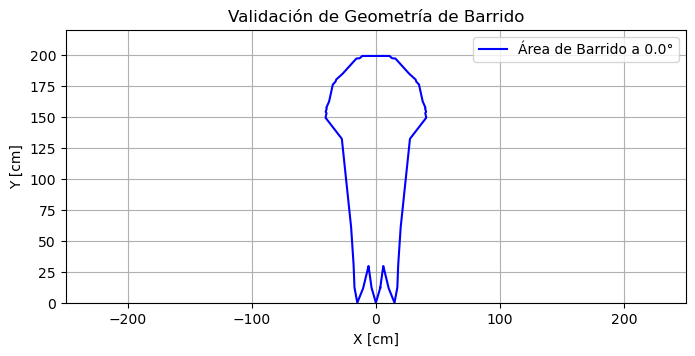

In [9]:
# ===================================================================
# Bloque de Validación y Visualización (para probar en el notebook)
# ===================================================================

print("Ángulos de barrido calculados (grados):")
print(np.round(ANGULOS_DE_BARRIDO, 2))

# Elige un ángulo de la lista para visualizar (ej. el segundo paso: 46.7°)
angulo_de_prueba = ANGULOS_DE_BARRIDO[4] 

# Genera el área de detección para ese ángulo
area_de_prueba = generar_area_de_barrido(angulo_de_prueba)

# Dibuja el resultado
fig, ax = plt.subplots(figsize=(8, 8))
if area_de_prueba.geom_type == 'Polygon':
    ax.plot(*area_de_prueba.exterior.xy, color='blue', label=f'Área de Barrido a {angulo_de_prueba:.1f}°')
elif area_de_prueba.geom_type == 'MultiPolygon':
    for poly in area_de_prueba.geoms:
        ax.plot(*poly.exterior.xy, color='blue')
    ax.scatter([],[], color='blue', label=f'Área de Barrido a {angulo_de_prueba:.1f}°') # Para la leyenda


ax.set_title("Validación de Geometría de Barrido")
ax.set_xlabel("X [cm]"); ax.set_ylabel("Y [cm]")
ax.set_xlim(-250, 250); ax.set_ylim(0, 220)
ax.set_aspect('equal', adjustable='box'); ax.grid(True)
ax.legend()
plt.show()

## Fase 3: Simulación de la Reflexión del Eco (Ray-Tracing Simplificado) 🌊

Esta es la parte más novedosa. Crearemos una función que imite cómo los sensores recibirían un eco de un objeto simulado.

    simular_reflexiones(objeto, angulo_central):

        Entrada: Un objeto (un polígono shapely) y el angulo_central del barrido.

        Proceso:

            Genera las geometrías de los tres haces para ese ángulo (haz_izq, haz_cen, haz_der).

            Para cada uno de los 3 sensores:

                Comprueba si su haz individual se interseca con el objeto.

                Si hay intersección, significa que ese sensor "ve" el objeto.

                Calcula la distancia desde el origen del sensor hasta el punto más cercano del objeto. Este será nuestro tiempo de vuelo simulado.

                Si no hay intersección, la distancia para ese sensor es infinita (o un valor muy grande).

        Salida: Devuelve una lista con los 3 tiempos de eco simulados.

In [19]:
# Importar las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely import affinity
import random

# ===================================================================
# FASE 1: Configuración y Parámetros (sin cambios)
# ===================================================================
DISTANCIA_ENTRE_SENSORES = 15
DISTANCIA_DE_ENFOQUE = 150
RANGO_DE_ANGULO = 140.0
NUMERO_DE_PASOS = 8
PASO_ANGULAR = RANGO_DE_ANGULO / (NUMERO_DE_PASOS - 1)
ANGULOS_DE_BARRIDO = np.linspace(-RANGO_DE_ANGULO / 2, RANGO_DE_ANGULO / 2, NUMERO_DE_PASOS)
SINGLE_BEAM_SHAPE_POINTS = [
    (0.00, 0.00), (0.035, 0.12), (0.06, 0.3), (0.11, 0.6), (0.255, 1.3),
    (0.405, 1.54), (0.32, 1.8), (0.11, 1.99), (-0.11, 1.99), (-0.32, 1.8),
    (-0.405, 1.54), (-0.255, 1.3), (-0.11, 0.6), (-0.06, 0.3), (-0.035, 0.12),
    (0.00, 0.00)
]
FACTOR_ESCALA_HAZ = 100.0

# ===================================================================
# FASE 2: Funciones de Modelado Geométrico (sin cambios)
# ===================================================================
def obtener_angulos_optimos(theta_central_deg, d, R):
    theta_central_math_rad = np.deg2rad(theta_central_deg + 90)
    px = R * np.cos(theta_central_math_rad)
    py = R * np.sin(theta_central_math_rad)
    angulo_math_izq = np.arctan2(py, px + d)
    angulo_final_izq = np.rad2deg(angulo_math_izq) - 90
    angulo_math_der = np.arctan2(py, px - d)
    angulo_final_der = np.rad2deg(angulo_math_der) - 90
    return angulo_final_izq, angulo_final_der

def crear_haz_desde_puntos(shape_points, scale_factor):
    scaled_points = [(x * scale_factor, y * scale_factor) for x, y in shape_points]
    return Polygon(scaled_points)

# ===================================================================
# FASE 3: Simulación de la Reflexión del Eco
# ===================================================================
# Esta nueva función simula los tiempos de eco para un objeto dado.

def simular_reflexiones(objeto, angulo_central):
    """
    Simula las distancias de eco de los 3 sensores a un objeto, para un
    ángulo de barrido específico.
    """
    # Orígenes de los sensores
    origen_s1 = Point(-DISTANCIA_ENTRE_SENSORES, 0)
    origen_s2 = Point(0, 0)
    origen_s3 = Point(DISTANCIA_ENTRE_SENSORES, 0)
    
    # Calcular los ángulos óptimos para el barrido
    angulo_izq, angulo_der = obtener_angulos_optimos(
        angulo_central,
        DISTANCIA_ENTRE_SENSORES,
        DISTANCIA_DE_ENFOQUE
    )
    
    # Crear la geometría base del haz
    haz_base = crear_haz_desde_puntos(SINGLE_BEAM_SHAPE_POINTS, FACTOR_ESCALA_HAZ)
    
    # Generar las geometrías de los tres haces en sus posiciones y orientaciones
    haz_central = affinity.rotate(haz_base, angulo_central, origin=(0, 0))
    haz_izq = affinity.translate(affinity.rotate(haz_base, angulo_izq, origin=(0, 0)), xoff=-DISTANCIA_ENTRE_SENSORES)
    haz_der = affinity.translate(affinity.rotate(haz_base, angulo_der, origin=(0, 0)), xoff=DISTANCIA_ENTRE_SENSORES)
    
    haces = [haz_izq, haz_central, haz_der]
    origenes = [origen_s1, origen_s2, origen_s3]
    distancias_eco = []
    
    # Para cada sensor, comprobar si "ve" el objeto
    for haz, origen in zip(haces, origenes):
        # La condición es que el objeto se superponga con el haz del sensor
        if objeto.intersects(haz):
            # La distancia del eco es la distancia desde el sensor al punto más cercano del objeto
            distancia = origen.distance(objeto)
            distancias_eco.append(distancia)
        else:
            # Si no hay intersección, el sensor no recibe eco de este objeto.
            # Usamos un valor muy grande para representar "sin eco".
            distancias_eco.append(np.inf)
            
    return distancias_eco, haces # Devolvemos los haces para poder visualizarlos

Resultados para un objeto en (-60.0, 120.0) con barrido a 23.3°:
--------------------------------------------------
Distancia simulada Sensor 1 (izq): 123.16 cm
Distancia simulada Sensor 2 (cen): 129.17 cm
Distancia simulada Sensor 3 (der): 136.51 cm
--------------------------------------------------


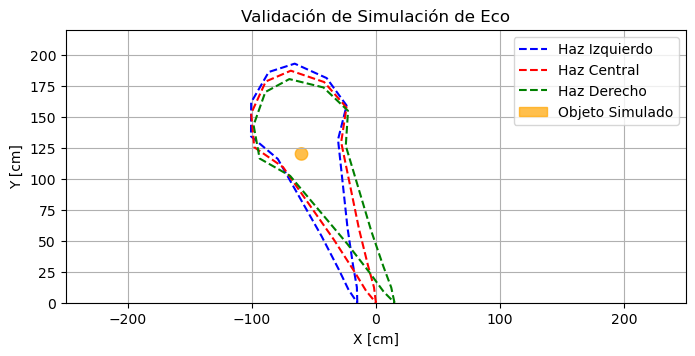

In [20]:
# ===================================================================
# Bloque de Validación y Visualización (para probar la Fase 3)
# ===================================================================

# 1. Elige un ángulo de barrido para la prueba
angulo_de_prueba = 23.3  # Puedes cambiar este valor

# 2. Crea un objeto de prueba (un círculo de 5 cm de radio) en una posición
#    que debería ser visible en ese ángulo de barrido.
objeto_de_prueba = Point(-60, 120).buffer(5)

# 3. Llama a la función de simulación
distancias, haces_de_prueba = simular_reflexiones(objeto_de_prueba, angulo_de_prueba)

print(f"Resultados para un objeto en ({objeto_de_prueba.centroid.x:.1f}, {objeto_de_prueba.centroid.y:.1f}) "
      f"con barrido a {angulo_de_prueba}°:")
print("-" * 50)
print(f"Distancia simulada Sensor 1 (izq): {distancias[0]:.2f} cm")
print(f"Distancia simulada Sensor 2 (cen): {distancias[1]:.2f} cm")
print(f"Distancia simulada Sensor 3 (der): {distancias[2]:.2f} cm")
print("-" * 50)


# 4. Visualiza el resultado para confirmación
fig, ax = plt.subplots(figsize=(8, 8))

# Dibuja los tres haces
colores = ['blue', 'red', 'green']
nombres = ['Haz Izquierdo', 'Haz Central', 'Haz Derecho']
for haz, color, nombre in zip(haces_de_prueba, colores, nombres):
    ax.plot(*haz.exterior.xy, color=color, linestyle='--', label=nombre)

# Dibuja el objeto de prueba
ax.fill(*objeto_de_prueba.exterior.xy, color='orange', alpha=0.7, label='Objeto Simulado')

ax.set_title("Validación de Simulación de Eco")
ax.set_xlabel("X [cm]"); ax.set_ylabel("Y [cm]")
ax.set_xlim(-250, 250); ax.set_ylim(0, 220)
ax.set_aspect('equal', adjustable='box'); ax.grid(True)
ax.legend()
plt.show()

## Fase 4: Generación del Dataset (Bucle Principal) 🔄

Este es el corazón del script, donde todo se une.

    Inicializar: Crea una rejilla de cuadrantes global que cubra todo el semicírculo de 180 grados y dos listas vacías: features y labels.

    Bucle Externo (por Ángulo): Itera sobre cada angulo_central en tu lista ANGULOS_DE_BARRIDO.

        Calcula el area_de_barrido para ese ángulo.

    Bucle Interno (por Muestra): Itera NUM_MUESTRAS_POR_PASO veces.

        Generar Objeto Aleatorio:

            Elige un tipo y tamaño de objeto al azar.

            Crea el polígono del objeto en una posición aleatoria dentro del area_de_barrido.

        Calcular la Etiqueta (Y): Determina con qué cuadrantes de la rejilla global se superpone el objeto. Esto genera el vector de salida (la "label").

        Calcular las Características (X):

            Llama a simular_reflexiones para obtener los 3 tiempos de eco.

            ¡Crucial! Pasa estos 3 tiempos a una versión simplificada de tu función output_dimention_pulses de helpers.py. Esto convertirá los tiempos de eco en la "firma de eco" de 243 valores, asegurando que tus datos simulados tengan el mismo formato que tus datos reales.

            Concatena el angulo_central con la firma de eco de 243 valores para crear el vector de características final (244 valores).

        Guardar: Añade el vector de características a features y el vector de etiquetas a labels.



In [24]:
# Importar las librerías necesarias para estas fases
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, box
from shapely.affinity import rotate, translate
import random
import pandas as pd
from tqdm.notebook import tqdm # Para una barra de progreso visual

# ===================================================================
# FASE 1: Configuración y Parámetros (sin cambios)
# ===================================================================
DISTANCIA_ENTRE_SENSORES = 15
DISTANCIA_DE_ENFOQUE = 150
RANGO_DE_ANGULO = 140.0
NUMERO_DE_PASOS = 9
PASO_ANGULAR = RANGO_DE_ANGULO / (NUMERO_DE_PASOS - 1)
ANGULOS_DE_BARRIDO = np.linspace(-RANGO_DE_ANGULO / 2, RANGO_DE_ANGULO / 2, NUMERO_DE_PASOS)
SINGLE_BEAM_SHAPE_POINTS = [
    (0.00, 0.00), (0.035, 0.12), (0.06, 0.3), (0.11, 0.6), (0.255, 1.3),
    (0.405, 1.54), (0.32, 1.8), (0.11, 1.99), (-0.11, 1.99), (-0.32, 1.8),
    (-0.405, 1.54), (-0.255, 1.3), (-0.11, 0.6), (-0.06, 0.3), (-0.035, 0.12),
    (0.00, 0.00)
]
FACTOR_ESCALA_HAZ = 100.0

# --- Parámetros de la Simulación ---
NUM_MUESTRAS_POR_PASO = 250  # Generaremos 250 objetos por cada ángulo de barrido
TIPOS_DE_OBJETO = ['circulo', 'rectangulo']
RANGO_DE_TAMAÑO_OBJETO = [5.0, 15.0] # en cm (radio para círculos, lado para cuadrados)
TAMAÑO_DEL_CUADRANTE = 6.0 # en cm
VELOCIDAD_SONIDO = 34300 # cm/s
FRECUENCIA_MUESTREO_ADC = 140000 # Hz (simula la captura cruda)
FRECUENCIA_MUESTREO_ML = 6800   # Hz (la frecuencia del espacio de características)


# ===================================================================
# FASE 2 y 3: Funciones Geométricas y de Simulación de Eco (sin cambios)
# ===================================================================
def obtener_angulos_optimos(theta_central_deg, d, R):
    theta_central_math_rad = np.deg2rad(theta_central_deg + 90)
    px = R * np.cos(theta_central_math_rad); py = R * np.sin(theta_central_math_rad)
    angulo_math_izq = np.arctan2(py, px + d); angulo_final_izq = np.rad2deg(angulo_math_izq) - 90
    angulo_math_der = np.arctan2(py, px - d); angulo_final_der = np.rad2deg(angulo_math_der) - 90
    return angulo_final_izq, angulo_final_der

def crear_haz_desde_puntos(shape_points, scale_factor):
    scaled_points = [(x * scale_factor, y * scale_factor) for x, y in shape_points]
    return Polygon(scaled_points)
    
def generar_area_de_barrido(angulo_central):
    angulo_izq, angulo_der = obtener_angulos_optimos(angulo_central, DISTANCIA_ENTRE_SENSORES, DISTANCIA_DE_ENFOQUE)
    haz_base = crear_haz_desde_puntos(SINGLE_BEAM_SHAPE_POINTS, FACTOR_ESCALA_HAZ)
    haz_central = rotate(haz_base, angulo_central, origin=(0, 0))
    haz_izq = translate(rotate(haz_base, angulo_izq, origin=(0, 0)), xoff=-DISTANCIA_ENTRE_SENSORES)
    haz_der = translate(rotate(haz_base, angulo_der, origin=(0, 0)), xoff=DISTANCIA_ENTRE_SENSORES)
    return haz_central.union(haz_izq).union(haz_der), [haz_izq, haz_central, haz_der]

def simular_reflexiones(objeto, haces_individuales):
    origenes = [Point(-DISTANCIA_ENTRE_SENSORES, 0), Point(0, 0), Point(DISTANCIA_ENTRE_SENSORES, 0)]
    distancias_eco = []
    for haz, origen in zip(haces_individuales, origenes):
        if objeto.intersects(haz):
            distancia = origen.distance(objeto)
            distancias_eco.append(distancia)
        else:
            distancias_eco.append(np.inf)
    return distancias_eco

# ===================================================================
# FASE 4: Generación del Dataset (Bucle Principal)
# ===================================================================

def distancias_a_firma_eco(distancias_cm):
    """
    Convierte las 3 distancias de eco simuladas a la "firma de eco" de 243 valores
    que espera el modelo de ML.
    """
    firma_eco_total = []
    ratio_conversion = FRECUENCIA_MUESTREO_ML / FRECUENCIA_MUESTREO_ADC
    
    for dist_cm in distancias_cm:
        firma_sensor = np.zeros(81)
        if dist_cm != np.inf:
            # Calcular tiempo de ida y vuelta
            tiempo_eco = (2 * dist_cm) / VELOCIDAD_SONIDO
            # Convertir tiempo a índice de muestra del ADC
            indice_adc = int(tiempo_eco * FRECUENCIA_MUESTREO_ADC)
            # Simular la transformación de `output_dimention_pulses`
            # Esta es una aproximación, asumiendo que el eco se mapea a un índice
            indice_ml = int((indice_adc - 100) * ratio_conversion) # Restamos 100 por el offset
            
            if 0 <= indice_ml < 81:
                firma_sensor[indice_ml] = 1
        firma_eco_total.extend(firma_sensor)
        
    return np.array(firma_eco_total)


def generar_objeto_aleatorio(area_madre):
    """Genera un objeto (círculo o rectángulo) en una posición aleatoria dentro del área dada."""
    min_x, min_y, max_x, max_y = area_madre.bounds
    tipo = random.choice(TIPOS_DE_OBJETO)
    tamaño = random.uniform(*RANGO_DE_TAMAÑO_OBJETO)
    
    # Intenta generar un objeto que esté completamente dentro del área
    for _ in range(50): # Limita los intentos para evitar bucles infinitos
        px = random.uniform(min_x, max_x)
        py = random.uniform(min_y, max_y)
        
        if tipo == 'circulo':
            objeto = Point(px, py).buffer(tamaño)
        else: # rectangulo
            objeto = box(px, py, px + tamaño, py + tamaño)
            
        if area_madre.contains(objeto):
            return objeto
            
    return None # No se pudo generar un objeto válido

# --- Bucle Principal de Generación ---
features_list = []
labels_list = []

# 1. Crear la rejilla de cuadrantes global
area_total_visible = box(-250, 0, 250, 220)
x_coords = np.arange(area_total_visible.bounds[0], area_total_visible.bounds[2], TAMAÑO_DEL_CUADRANTE)
y_coords = np.arange(area_total_visible.bounds[1], area_total_visible.bounds[3], TAMAÑO_DEL_CUADRANTE)
cuadrantes_globales = [box(x, y, x + TAMAÑO_DEL_CUADRANTE, y + TAMAÑO_DEL_CUADRANTE) for x in x_coords for y in y_coords]
num_cuadrantes = len(cuadrantes_globales)


print(f"Generando dataset con {NUMERO_DE_PASOS} pasos angulares...")
# Bucle Externo: Itera sobre cada ángulo de barrido
for angulo_central in tqdm(ANGULOS_DE_BARRIDO, desc="Progreso del Barrido"):
    
    # Genera el área de detección y los haces individuales para este ángulo
    area_de_barrido, haces_individuales = generar_area_de_barrido(angulo_central)
    
    # Bucle Interno: Genera N muestras por cada ángulo
    for _ in range(NUM_MUESTRAS_POR_PASO):
        
        # Genera un objeto aleatorio dentro del área de este barrido
        objeto = generar_objeto_aleatorio(area_de_barrido)
        if objeto is None: continue # Si no se pudo generar, saltar

        # --- Calcular la Etiqueta (Y) ---
        label = np.zeros(num_cuadrantes)
        for i, cuadrante in enumerate(cuadrantes_globales):
            if objeto.intersects(cuadrante):
                label[i] = 1
        
        # --- Calcular las Características (X) ---
        distancias_eco = simular_reflexiones(objeto, haces_individuales)
        firma_eco_ml = distancias_a_firma_eco(distancias_eco)
        
        # Feature final: [angulo, eco_s1..., eco_s2..., eco_s3...]
        feature = np.concatenate(([angulo_central], firma_eco_ml))
        
        # Guardar en las listas
        features_list.append(feature)
        labels_list.append(label)

print("\nGeneración del dataset completada.")
print(f"Total de muestras generadas: {len(features_list)}")

# ===================================================================
# FASE 5: Guardado de Archivos
# ===================================================================

# Convertir a DataFrames y guardar
df_features = pd.DataFrame(features_list)
df_labels = pd.DataFrame(labels_list)

df_features.to_csv("features_simuladas.csv", index=False)
df_labels.to_csv("labels_simuladas.csv", index=False)

print("\nArchivos 'features_simuladas.csv' y 'labels_simuladas.csv' guardados.")

Generando dataset con 9 pasos angulares...


Progreso del Barrido:   0%|          | 0/9 [00:00<?, ?it/s]


Generación del dataset completada.
Total de muestras generadas: 2250

Archivos 'features_simuladas.csv' y 'labels_simuladas.csv' guardados.


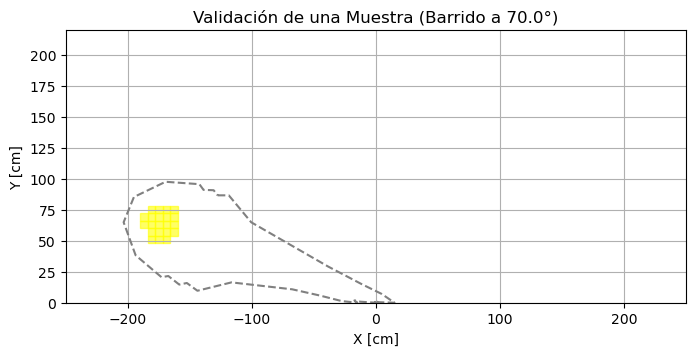

In [28]:
# ===================================================================
# Bloque de Validación y Visualización (para probar una muestra)
# ===================================================================

# Tomar la última muestra generada para visualizar
ultima_feature = features_list[-5]
ultima_label = labels_list[-5]

angulo_muestra = ultima_feature[0]
area_muestra, _ = generar_area_de_barrido(angulo_muestra)
cuadrantes_activos_indices = np.where(ultima_label == 1)[0]

fig, ax = plt.subplots(figsize=(8, 8))

# Dibujar el área de barrido de esta muestra
if area_muestra.geom_type == 'Polygon': ax.plot(*area_muestra.exterior.xy, color='gray', linestyle='--')
elif area_muestra.geom_type == 'MultiPolygon':
    for poly in area_muestra.geoms: ax.plot(*poly.exterior.xy, color='gray', linestyle='--')

# Resaltar los cuadrantes activos
for idx in cuadrantes_activos_indices:
    cuadrante = cuadrantes_globales[idx]
    ax.fill(*cuadrante.exterior.xy, color='yellow', alpha=0.6)

ax.set_title(f"Validación de una Muestra (Barrido a {angulo_muestra:.1f}°)")
ax.set_xlabel("X [cm]"); ax.set_ylabel("Y [cm]")
ax.set_xlim(-250, 250); ax.set_ylim(0, 220)
ax.set_aspect('equal', adjustable='box'); ax.grid(True)
plt.show()